TokaMaker Example 3: Baseline L-mode scenario in ITER {#doc_tMaker_ITER_ex2}
==========
In this example we show how to compute equilibria in ITER with L-mode like profiles for:
 1. The "inverse" case where we have a desired shape, plasma current and pressure, but the required coil currents are unkown
 2. The "forward" case where we have already have coil currents, plasma current, and known position for the desired equilibrium

This example utilizes the mesh built in \ref doc_tMaker_ITER_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_recon
Revision id:          de5ae58
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_ITER_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.827E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.0219999999999999E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. In this case we use the actual ITER Vertical Stability Coil (VSC).

**Note:** While ITER has a "real" VSC, this is not required and this functionality can instead be used to define a "virtual" VSC by pairing coils in a way that are not necessarily paired experimentally.

In [5]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[mygs.coil_sets['VS']['id']] = 1.0
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [6]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -50.E6; coil_bounds[:,1] = 50.E6
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [7]:
Ip_target=15.6E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [8]:
isoflux_pts = np.array([
    [ 8.20,  0.41],
    [ 8.06,  1.46],
    [ 7.51,  2.62],
    [ 6.14,  3.78],
    [ 4.51,  3.02],
    [ 4.26,  1.33],
    [ 4.28,  0.08],
    [ 4.49, -1.34],
    [ 7.28, -1.89],
    [ 8.00, -0.68]
])
x_point = np.array([[5.125, -3.4],])
mygs.set_isoflux(np.vstack((isoflux_pts,x_point)))
mygs.set_saddles(x_point)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on the CS and PF coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the weight on the VSC virtual coil defined above is set high to prevent interaction with the real `VS` coil set (see below for further information).

In [9]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Set regularization weights
for key, coil in mygs.coil_sets.items():
    if key.startswith('CS'):
        if key.startswith('CS1'):
            coil_reg_weights[coil['id']] = 2.E-2
        else:
            coil_reg_weights[coil['id']] = 1.E-2
    elif key.startswith('PF'):
        coil_reg_weights[coil['id']] = 1.E-2
    elif key.startswith('VS'):
        coil_reg_weights[coil['id']] = 1.E-2
# Set weight for VSC virtual coil
coil_reg_weights[-1] = 1.E2

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

**Note:** More tools to aide in setting these profiles are coming soon

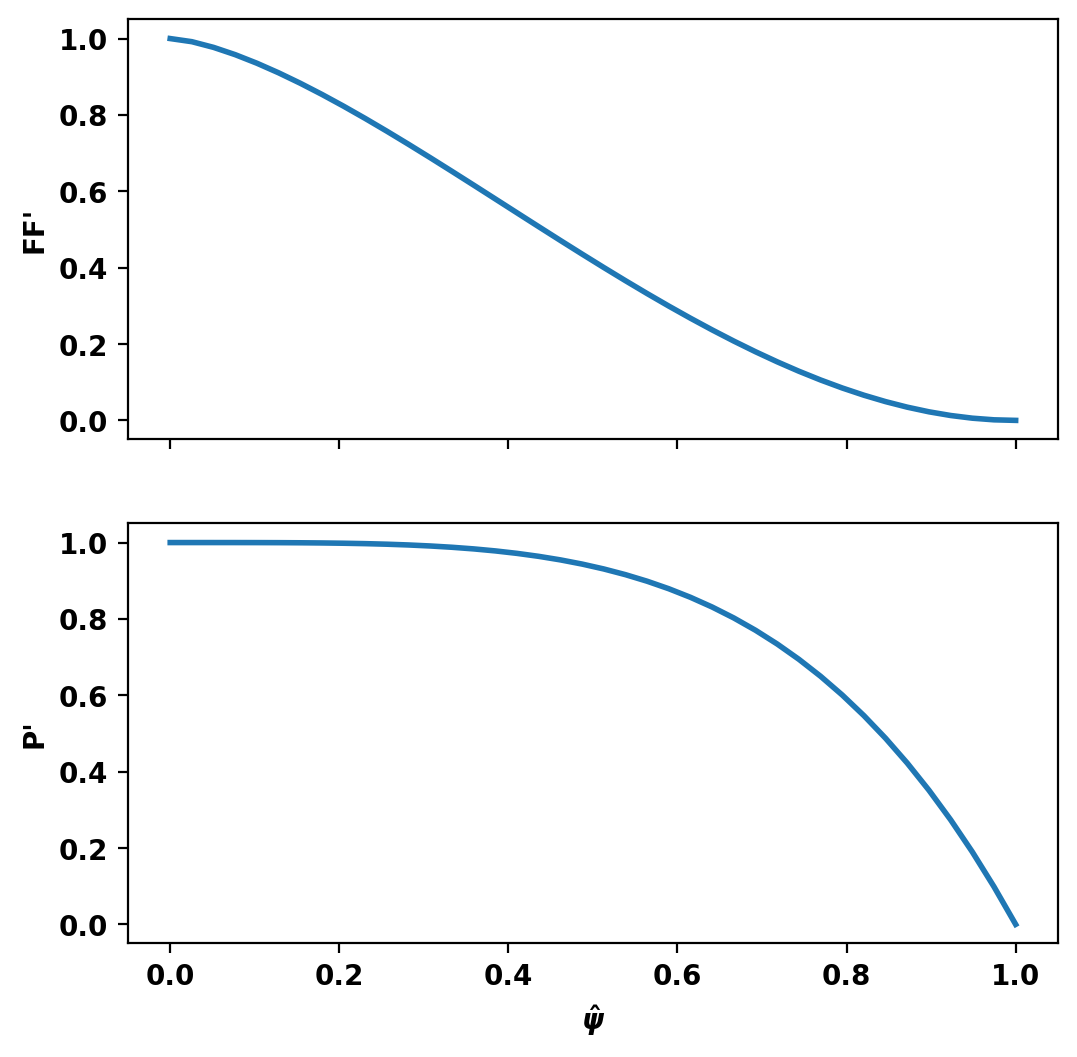

In [10]:
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 1.5
gamma = 2.0
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 4.0
gamma = 1.0
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [11]:
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  5.7964E+00  1.5693E-01  6.4678E-01  6.4426E+00  5.3471E-01  9.8348E-04
     2  1.5480E+01  9.5056E-02  2.7461E-01  6.4070E+00  5.3339E-01  1.5938E-03
     3  1.9148E+01  7.9380E-02  1.2980E-01  6.3865E+00  5.3263E-01  1.6630E-03
     4  2.0950E+01  7.3407E-02  6.7567E-02  6.3756E+00  5.3231E-01  1.6305E-03
     5  2.1908E+01  7.0680E-02  3.6961E-02  6.3696E+00  5.3223E-01  1.5882E-03
     6  2.2433E+01  6.9312E-02  2.0656E-02  6.3664E+00  5.3227E-01  1.5558E-03
     7  2.2724E+01  6.8590E-02  1.1646E-02  6.3646E+00  5.3236E-01  1.5342E-03
     8  2.2888E+01  6.8197E-02  6.5901E-03  6.3636E+00  5.3246E-01  1.5207E-03
     9  2.2980E+01  6.7980E-02  3.7354E-03  6.3630E+00  5.3254E-01  1.5127E-03
    10  2.3032E+01  6.7859E-02  2.1196E-03  6.3627E+00  5.3261E-01  1.5079E-03
    11  2.3061E+01  6.7791E-02  1.2038E-03  6.3626E+00  5.3267E-01  1.5051E-03
    12  2.3078E+01  6.7753E-02  6.8427E-04  6.3625E+00  5.3270E-01  1.5035E-03
    13  2.3087E+01  6.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

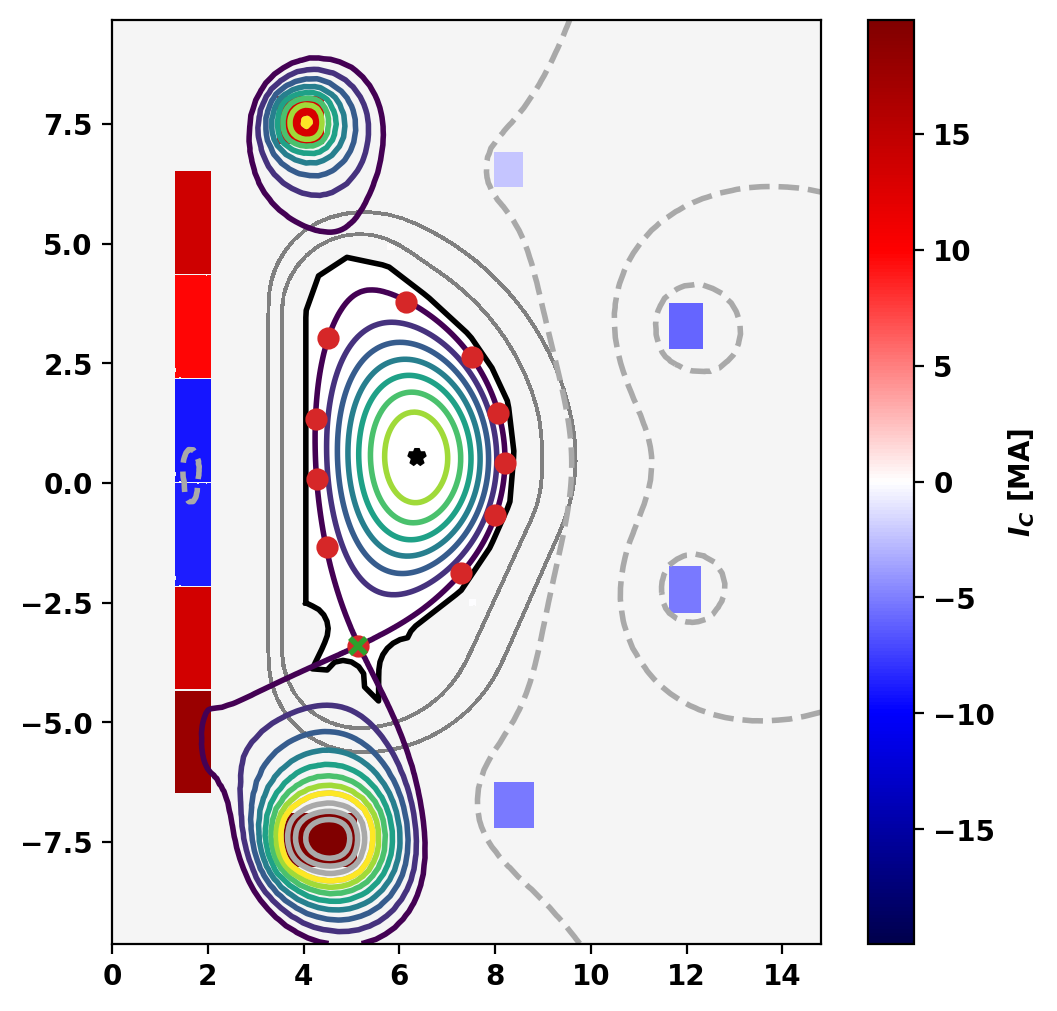

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method, which are all within the approximate coil limits imposed above.

In [13]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.5600E+07
  Current Centroid [m]    =    6.203  0.530
  Magnetic Axis [m]       =    6.362  0.533
  Elongation              =    1.868 (U:  1.739, L:  1.997)
  Triangularity           =    0.464 (U:  0.383, L:  0.544)
  Plasma Volume [m^3]     =   820.097
  q_0, q_95               =    0.823  2.760
  Peak Pressure [Pa]      =    6.1923E+05
  Stored Energy [J]       =    2.4299E+08
  <Beta_pol> [%]          =   39.7500
  <Beta_tor> [%]          =    1.7689
  Diamagnetic flux [Wb]   =    1.5403E+00
  Toroidal flux [Wb]      =    1.2187E+02
  l_i                     =    0.9049

Coil Currents [MA]:
  CS3U:           13.74
  CS2U:            9.74
  CS1U:           -9.06
  CS1L:           -8.81
  CS2L:           13.40
  CS3L:           17.88
  PF1:            12.94
  PF2:            -2.20
  PF3:            -5.95
  PF4:            -5.14
  PF5:            -5.18
  PF6:            19.93
  VS:         

In [14]:
import json
with open('ITER_geom.json','r') as fid:
    ITER_geom = json.load(fid)
    probe_contour = np.asarray(ITER_geom['inner_vv'][0])
#
dl_contour = np.r_[0.0, np.cumsum(np.linalg.norm(np.diff(probe_contour,axis=0),axis=1))]
probe_contour_new = np.zeros((100,2))
probe_contour_new[:,0] = np.interp(np.linspace(0.0,dl_contour[-1],100),dl_contour,probe_contour[:,0])
probe_contour_new[:,1] = np.interp(np.linspace(0.0,dl_contour[-1],100),dl_contour,probe_contour[:,1])
#
B_locs = []
for i, pt in enumerate(probe_contour_new):
    if i % 5 == 0:
        B_locs.append(pt)
B_locs = np.asarray(B_locs)

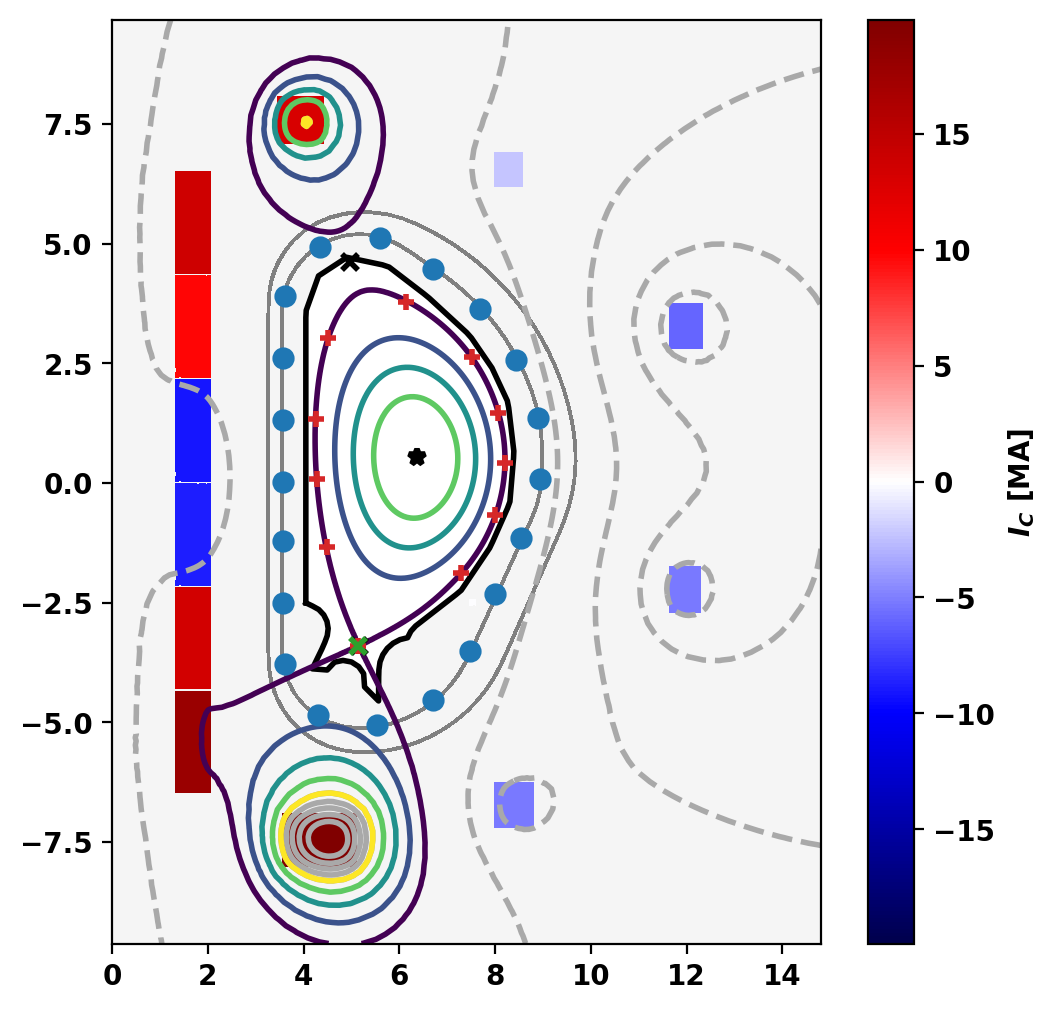

In [15]:
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
ax.plot(B_locs[:,0], B_locs[:,1], 'o')

In [16]:
myrecon = reconstruction(mygs)

In [17]:
noise_amp = (random.random()-0.5)*2.0
myrecon.set_Ip(1.56E7+noise_amp*0.05*1.56E7, err=0.05*1.56E7)
# myrecon.set_Ip(1.56E7, err=0.05*1.56E7)

In [18]:
flux_vals = []
field_eval = mygs.get_field_eval('PSI')
for i in range(B_locs.shape[0]):
    B_tmp = field_eval.eval(B_locs[i,:])
    noise_amp = (random.random()-0.5)*2.0
    flux_vals.append(B_tmp[0])
    psi_val = B_tmp[0]*2.0*np.pi
    myrecon.add_flux_loop(B_locs[i,:], psi_val + noise_amp*abs(psi_val*0.05), err=abs(psi_val*0.05))

In [19]:
field_eval = mygs.get_field_eval('B')
for i in range(B_locs.shape[0]):
    B_tmp = field_eval.eval(B_locs[i,:])
    noise_amp = (random.random()-0.5)*2.0
    myrecon.add_Mirnov(B_locs[i,:], np.r_[1.0,0.0,0.0], B_tmp[0] + noise_amp*abs(B_tmp[0]*0.05), err=abs(B_tmp[0]*0.05))
    noise_amp = (random.random()-0.5)*2.0
    myrecon.add_Mirnov(B_locs[i,:], np.r_[0.0,0.0,1.0], B_tmp[2] + noise_amp*abs(B_tmp[2]*0.05), err=abs(B_tmp[2]*0.05))

In [20]:
coil_currents, _ = mygs.get_coil_currents()
for i in range(coil_currents.shape[0]):
    noise_amp = (random.random()-0.5)*2.0
    coil_currents[i] *= 1.0+noise_amp*0.05
mygs.set_coil_currents(coil_currents)

In [21]:
mygs.set_isoflux(None)
mygs.set_saddles(None)
Ip_target = 1.4E7
mygs.set_targets(R0=mygs.o_point[0]-0.05,V0=mygs.o_point[1])
mygs.solve()

Starting non-linear GS solver
     1  2.3100E+01  6.8390E-02  2.4262E-02  6.3624E+00  5.3279E-01 -2.4568E+04
     2  2.3100E+01  6.4120E-02  6.0854E-03  6.3557E+00  5.3279E-01 -2.0163E+04
     3  2.3100E+01  6.4209E-02  4.3674E-03  6.3477E+00  5.3279E-01 -1.8016E+04
     4  2.3100E+01  6.4725E-02  4.1274E-03  6.3395E+00  5.3277E-01 -1.7785E+04
     5  2.3100E+01  6.5221E-02  3.8891E-03  6.3311E+00  5.3279E-01 -1.8967E+04
     6  2.3100E+01  6.5508E-02  3.8130E-03  6.3228E+00  5.3279E-01 -1.9307E+04
     7  2.3100E+01  6.5727E-02  3.7982E-03  6.3144E+00  5.3279E-01 -1.9886E+04
     8  2.3100E+01  6.9455E-02  3.0953E-03  6.3128E+00  5.3279E-01 -1.7280E+04
     9  2.3100E+01  6.8840E-02  2.0167E-03  6.3124E+00  5.3279E-01 -1.7775E+04
    10  2.3100E+01  6.8076E-02  9.7012E-04  6.3124E+00  5.3279E-01 -1.7715E+04
    11  2.3100E+01  6.7660E-02  4.0601E-04  6.3124E+00  5.3279E-01 -1.7586E+04
    12  2.3100E+01  6.7479E-02  1.6075E-04  6.3124E+00  5.3279E-01 -1.7495E+04
    13  2.3100E+01  6.

0

In [22]:
mygs.set_targets(Ip=1.56E7,Ip_ratio=1.0)
mygs.set_flux(B_locs,np.array(flux_vals))
#
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-1*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))
coil_reg_weights[-1] = 1.E2
coil_reg_targets[:-1] = coil_currents

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)
#
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
mygs.settings.maxits=100
mygs.update_settings()
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  1.7906E+01  1.2804E-01  1.0551E-01  6.3480E+00  5.0549E-01  1.4431E-01
     2  1.7061E+01  1.1317E-01  4.6103E-02  6.3690E+00  4.9985E-01  1.0373E-01
     3  1.6633E+01  1.0900E-01  2.2530E-02  6.3861E+00  4.9806E-01  8.0842E-02
     4  1.6460E+01  1.0743E-01  1.1762E-02  6.3982E+00  4.9820E-01  6.7531E-02
     5  1.6396E+01  1.0676E-01  6.4517E-03  6.4062E+00  4.9926E-01  5.9772E-02
     6  1.6373E+01  1.0644E-01  3.6732E-03  6.4113E+00  5.0069E-01  5.5257E-02
     7  1.6366E+01  1.0627E-01  2.1643E-03  6.4144E+00  5.0222E-01  5.2586E-02
     8  1.6363E+01  1.0617E-01  1.3285E-03  6.4163E+00  5.0372E-01  5.0961E-02
     9  1.6360E+01  1.0610E-01  8.6612E-04  6.4175E+00  5.0513E-01  4.9933E-02
    10  1.6358E+01  1.0606E-01  6.1412E-04  6.4182E+00  5.0642E-01  4.9252E-02
    11  1.6355E+01  1.0602E-01  4.7642E-04  6.4187E+00  5.0759E-01  4.8780E-02
    12  1.6353E+01  1.0599E-01  3.9670E-04  6.4189E+00  5.0865E-01  4.8438E-02
    13  1.6350E+01  1.

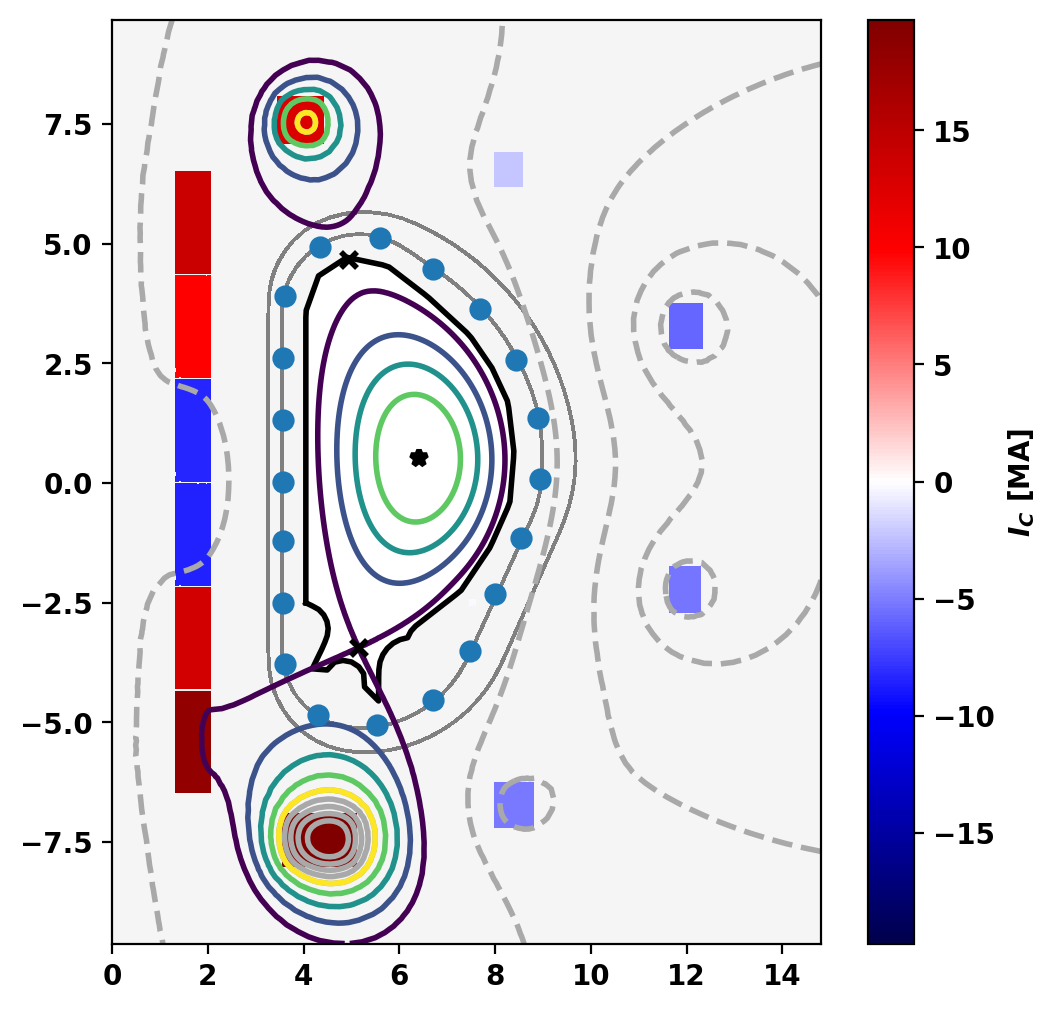

In [23]:
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
ax.plot(B_locs[:,0], B_locs[:,1], 'o')

In [24]:
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)
mygs.settings.maxits=100
mygs.update_settings()
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitCoils = True
myrecon.settings.pm = False
myrecon.reconstruct()


*** Loading fit constraints ***
 Fixed           0           0

Starting Fit:
  # of free parameters   =   15
  # of constraints       =   74

Function evaluation    1
  Alam              =  1.632E+01
  P_scale           =  1.058E-01
  R0_target         =  6.419E+00
  V0_target         =  5.176E-01
  Coil currents [%]  =  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00
  Maximum Rel Error =  4.181E-01
  Maximum Abs Error =  6.418E+05
  Total Weighted Error   =  1.186E+01
  RMS Weighted Error     =  1.379E+00

Function evaluation    2
  Alam              =  1.632E+01
  P_scale           =  1.058E-01
  R0_target         =  6.419E+00
  V0_target         =  5.176E-01
  Coil currents [%]  =  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00
  Maximum Rel Error =  4.181E-01
  Maximum Abs Error =  6.418E+05
 

0

In [25]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.5648E+07
  Current Centroid [m]    =    6.204  0.513
  Magnetic Axis [m]       =    6.364  0.518
  Elongation              =    1.875 (U:  1.743, L:  2.007)
  Triangularity           =    0.464 (U:  0.382, L:  0.545)
  Plasma Volume [m^3]     =   817.636
  q_0, q_95               =    0.835  2.757
  Peak Pressure [Pa]      =    6.6568E+05
  Stored Energy [J]       =    2.6210E+08
  <Beta_pol> [%]          =   42.7296
  <Beta_tor> [%]          =    1.9144
  Diamagnetic flux [Wb]   =    1.4746E+00
  Toroidal flux [Wb]      =    1.2151E+02
  l_i                     =    0.8889

Coil Currents [MA]:
  CS3U:           13.98
  CS2U:            9.65
  CS1U:           -8.59
  CS1L:           -8.69
  CS2L:           13.21
  CS3L:           18.45
  PF1:            13.05
  PF2:            -2.22
  PF3:            -5.94
  PF4:            -5.26
  PF5:            -4.99
  PF6:            19.63
  VS:         